In [1207]:
#Import libraries
import uproot
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import time
import math
import pandas as pd

In [1208]:
pwd

'/Users/christopheralpert/Documents/Eductation/Physics/CERN/DiVertAnalysis/ANA-EXOT-2019-24-INTL'

In [1209]:
#Load Sig File
sig_file = uproot.open("user.calpert.mc16_13TeV.311423.MGPy8EG_A14NNPDF23_NNPDF31ME_HSS_LLP_mH600_mS150_lthigh.032123_trees.root/user.calpert.311423.e7357_e5984_s3234_r10201_r10210_p4696.32829947._000001.trees.root:trees_DV_")

In [1210]:
#Define helper functions. These functions display relevant info about a branch if needed.
def dp(branch, length):
    if length > len(branch):
        length = len(branch)  # Ensures we do not go out of range if length is greater than the branch size
    for i, value in enumerate(branch[:length]):
        print("Value:", value, "   Index:", i)

def ratio(branch):
    ratio = ak.count_nonzero(branch)/ak.count(branch)
    print(ratio) #Display ratio of number of elements that pass

In [1211]:
#Display all columns
pd.set_option('display.max_columns', None)

## Vertex Data

In [1212]:
#Load signal features
mdt = sig_file["MSVtx_nMDT"].array()
rpc = sig_file["MSVtx_nRPC"].array()
tgc = sig_file["MSVtx_nTGC"].array()
ntrks = sig_file['MSVtx_nTrks'].array()
vtx_eta = sig_file["MSVtx_eta"].array()
vtx_phi = sig_file["MSVtx_phi"].array()
sumpt = sig_file['MSVtx_sumTrackPt0p2Cone'].array()

In [1213]:
#Before flattening to numpy, I need to reference event # to each value of vertex
##### NOTE: LOOK FOR A WORKAROUND THAT DOESN'T INVOLVE FLATTENING TO NUMPY #####

dummy_vtx= ak.zeros_like((mdt)) #Create a dummy array that captures the structure of the vertex branches
lengths = ak.num(dummy) 
eventnp = ak.to_numpy((ak.concatenate([ak.Array([i]*lengths[i]) for i in range(len(mdt))])))
eventnp_series = pd.Series(eventnp)

In [1214]:
#Define function to duplicate necessary rows in a series

#Create a duplication index that corresponds to rows >1 vertex per event
dup_index=[]
for i in range(len(eventnp)-1):
    if eventnp[i]==eventnp[i+1]:
        dup_index.append(i)
        
#This function duplicates a row that exists in a pandas dataframe. 
    #Necessary for mapping event-level data to vtx level dimension

def dup_row(df,index):
    for i in index:
        # Index of the row to duplicate
        row_index = i

        # Split the DataFrame into two parts: before and after the row to be duplicated
        before_row = df.iloc[:row_index + 1]
        after_row = df.iloc[row_index + 1:]

        # Duplicate the row
        duplicated_row = df.iloc[row_index:row_index + 1]

        # Concatenate the parts along with the duplicated row in between
        df = pd.concat([before_row, duplicated_row, after_row], ignore_index=True)
    return df

In [1215]:
#Calculate vertex multiplicity
mult = np.zeros(len(dummy_vtx))
for i in range(len(dummy_vtx)):
    mult[i] = ak.num(dummy_vtx[i],axis=0)

In [1216]:
#Create series for vertex data 
mdt_series = pd.Series(ak.to_numpy(ak.flatten(mdt)))
rpc_series = pd.Series(ak.to_numpy(ak.flatten(rpc)))
tgc_series = pd.Series(ak.to_numpy(ak.flatten(tgc)))
ntrks_series = pd.Series(ak.to_numpy(ak.flatten(ntrks)))
vtx_eta_series = pd.Series(ak.to_numpy(ak.flatten(vtx_eta)))
vtx_phi_series = pd.Series(ak.to_numpy(ak.flatten(vtx_phi)))
sumpt_series = pd.Series(ak.to_numpy(ak.flatten(sumpt)))
mult_series=dup_row(pd.Series(mult), dup_index)

In [1217]:
#Create vertex data Frame
df_vtx = pd.concat({"Event #":eventnp_series, "Mult":mult_series, "MDT":mdt_series,"RPC":rpc_series,"TGC":tgc_series,"ntrks":ntrks_series,"Vtx_eta":vtx_eta_series,"Vtx_phi":vtx_phi_series,"Vtx_Sum_pT":sumpt_series},axis=1)

In [1218]:
df_vtx   #Most of these values are correspond to no vertex present.

,Event #,Mult,MDT,RPC,TGC,ntrks,Vtx_eta,Vtx_phi,Vtx_Sum_pT
0,0,1.0,-99999,-99999,-99999,-99999,-99999.000000,-99999.000000,-99999.0
1,1,1.0,-99999,-99999,-99999,-99999,-99999.000000,-99999.000000,-99999.0
2,2,1.0,-99999,-99999,-99999,-99999,-99999.000000,-99999.000000,-99999.0
3,3,1.0,-99999,-99999,-99999,-99999,-99999.000000,-99999.000000,-99999.0
4,4,1.0,1381,0,1127,4,-1.700868,-1.715319,0.0
...,...,...,...,...,...,...,...,...,...
51058,49995,1.0,-99999,-99999,-99999,-99999,-99999.000000,-99999.000000,-99999.0
51059,49996,1.0,-99999,-99999,-99999,-99999,-99999.000000,-99999.000000,-99999.0
51060,49997,1.0,-99999,-99999,-99999,-99999,-99999.000000,-99999.000000,-99999.0
51061,49998,1.0,-99999,-99999,-99999,-99999,-99999.000000,-99999.000000,-99999.0


In [1219]:
#Check pct of values that are bad vertices
pct = ak.sum(mdt==-99999)/ak.count(mdt)
print(pct*100)

76.2332804574741


In [1220]:
#Verify length of dataframe is correct
len(ak.flatten(dummy)) == len(df_vtx)

True

In [1221]:
#Inspect what this looks like for bad vertices removed. Remove these later after all data is present
df_vtx_clean = df_vtx[df_vtx['MDT']!=-99999]
df_vtx_clean

,Event #,Mult,MDT,RPC,TGC,ntrks,Vtx_eta,Vtx_phi,Vtx_Sum_pT
4,4,1.0,1381,0,1127,4,-1.700868,-1.715319,0.000000
6,6,2.0,2031,1975,1063,9,-1.037559,-0.770241,0.000000
7,6,2.0,2069,1842,1126,3,-1.211802,-0.766565,658.664118
13,12,1.0,685,0,752,13,-1.606205,-2.919309,544.256762
14,13,1.0,905,443,10,7,0.903355,1.364382,0.000000
...,...,...,...,...,...,...,...,...,...
51033,49970,1.0,1600,27,2103,14,-1.502829,0.858940,0.000000
51036,49973,1.0,939,0,802,13,2.518463,-0.807060,0.000000
51038,49975,1.0,3118,887,2151,9,1.342875,2.523968,0.000000
51042,49979,1.0,777,1488,0,8,-0.286740,-2.810499,0.000000


## Jet Data

In [1222]:
#Load jet features
jet_eta = sig_file["jet_eta"].array()
jet_phi = sig_file["jet_phi"].array()
jet_pt = sig_file["jet_pT"].array()
jet_logRatio = sig_file['jet_logRatio'].array()
jet_jvt = sig_file["jet_jvt"].array()

In [ ]:
dummy_jet= ak.zeros_like((jet_pt))

In [1223]:
#Find delta jet - vtx and pick jet with smallest delta
jet_vtx_etaPairs = ak.cartesian({"x":jet_eta, "y":vtx_eta}, axis=1) 
jet_vtx_phiPairs = ak.cartesian({"x":jet_phi, "y":vtx_phi}, axis=1) 

delta_jet_eta = abs(jet_vtx_etaPairs["x"] - jet_vtx_etaPairs["y"])
delta_jet_phi = abs(jet_vtx_phiPairs["x"] - jet_vtx_phiPairs["y"])

delta_jet = (delta_jet_eta * delta_jet_eta) + (delta_jet_phi * delta_jet_phi)

In [1224]:
#This function will find the nth smallest values  for each event, and create attach a corresponding index to reference in the training set
def find_nth_smallest_values(awk_array, n_values):
    nth_smallest_values = {n: [] for n in n_values}
    indices_of_nth_smallest_values = {n: [] for n in n_values}

    for branch in awk_array:
        branch_length = len(branch)
        sorted_array = np.sort(ak.to_numpy(branch)) if branch_length else []
        
        for n in n_values:
            if branch_length >= n:
                value = sorted_array[n-1]
                original_index = np.where(ak.to_numpy(branch) == value)[0][0]
                nth_smallest_values[n].append(value)
                indices_of_nth_smallest_values[n].append(original_index)
            else:
                nth_smallest_values[n].append(np.nan)
                indices_of_nth_smallest_values[n].append(-1)

    # Convert lists to awkward arrays before returning
    for n in n_values:
        nth_smallest_values[n] = ak.Array(nth_smallest_values[n])
        indices_of_nth_smallest_values[n] = ak.Array(indices_of_nth_smallest_values[n])
    
    return nth_smallest_values, indices_of_nth_smallest_values

#This function will select the element of a given array that corresponds to the elements determined by nth smallest values
def element_select(awk_array, index_array):

    result = [branch[index] if (0 <= index < len(branch)) else np.nan for branch, index in zip(awk_array, index_array)]

    # Otherwise, keep it as a list or convert to a NumPy array if preferred
    result_np = np.array(result)

    return result_np



In [1225]:
#Before running, check which indices of jet_pt have 0 length. Use these indices to check in your training data set
#Be prepared for divide by zero warning!
jet_length = ak.num(dummy_jet)

# Finding indices where lengths are zero
jet_length_indices = ak.where(jet_length == 0)[0]

# Print or use the zero length indices
print("Indices with zero length in jet_pt:", jet_length_indices)

Indices with zero length in jet_pt: [9005, 10373, 11327, 11376, 13274, 14846, ... 32728, 41293, 41401, 47535, 49694]


In [1226]:
#This is the main function that finds the smallest delta jet per event and maps it correctly to the appropriate index in
#desired jet array. n_indices is used to compute the first n jets that correspond to the n smallest deltas

def jet_index_mod(jet_index, dummy_vtx, dummy_jet):
    # Initialize the corrected indices array
    jet_index_cor = np.empty_like(jet_index)
    
    # Iterate over each index in jet_index
    for i in range(len(jet_index)):
        len_a = len(dummy_vtx[i])  # Length of the corresponding entry in vtx_eta
        len_b = len(dummy_jet[i])  # Length of the corresponding entry in jet_pt
        k = jet_index[i]           # Current flat index from the Cartesian product

        # Calculate the corrected index for jet_pt
        jet_index_cor[i] = k % len_b

    return jet_index_cor

# Array of indices for which you want to find the N-th smallest values
n_indices = [1,2,3]   #Define how many jets you'd like to display in the training set

# Call the master function once instead of multiple times for different values
nth_smallest_deltas, nth_indices = find_nth_smallest_values(delta_jet, n_indices)

#Create the appopriate arrays with selected jet elements

for n in n_indices:
    # Extract the current jet_index
    jet_index = ak.to_numpy(nth_indices[n])
    
    # Correct the jet_index based on the lengths in vtx_eta and jet_pt
    corrected_jet_index = jet_index_mod(jet_index, dummy_vtx, dummy_jet)
    
    # Now you can use corrected_jet_index for further operations, e.g., accessing jet_pt
    globals()[f'jet_pt_{n}'] = element_select(jet_pt, corrected_jet_index)
    globals()[f'jet_eta_{n}'] = element_select(jet_eta, corrected_jet_index)
    globals()[f'jet_phi_{n}'] = element_select(jet_phi, corrected_jet_index)
    globals()[f'jet_logRatio_{n}'] = element_select(jet_logRatio, corrected_jet_index)
    globals()[f'jet_jvt_{n}'] = element_select(jet_jvt, corrected_jet_index)
    globals()[f'delta_jet_{n}'] = element_select(delta_jet, corrected_jet_index)


<ipython-input-1226-3d5f7fe853de>:15: RuntimeWarning: divide by zero encountered in long_scalars
  jet_index_cor[i] = k % len_b


In [1227]:
# Create pandas Series for each array
series_list = []
for n in n_indices:  # For each of the N-th smallest values
    jet_pt_series = pd.Series(globals()[f'jet_pt_{n}'], name=f'jet_pt_{n}')
    jet_eta_series = pd.Series(globals()[f'jet_eta_{n}'], name=f'jet_eta_{n}')
    jet_phi_series = pd.Series(globals()[f'jet_phi_{n}'], name=f'jet_phi_{n}')
    jet_logRatio_series = pd.Series(globals()[f'jet_logRatio_{n}'], name=f'jet_logRatio_{n}')
    jet_jvt_series = pd.Series(globals()[f'jet_jvt_{n}'], name=f'jet_jvt_{n}')
    delta_jet_series = pd.Series(globals()[f'delta_jet_{n}'], name=f'delta_jet_{n}')
    
    # Concatenate the Series for the current N-th smallest values into a DataFrame
    nth_dataframe = pd.concat([jet_pt_series, jet_eta_series, jet_phi_series, jet_logRatio_series, jet_jvt_series, delta_jet_series], axis=1)
    
    # Append the DataFrame to the list
    series_list.append(nth_dataframe)

# Concatenate all DataFrames vertically
df_jet = pd.concat(series_list, axis=1)

In [1228]:
#Map to vertex
df_jet = dup_row(df_jet, dup_index)

#Create df_jet
df_vtx_jet = pd.concat([df_vtx, df_jet], axis=1)

In [1229]:
df_vtx_jet

,Event #,Mult,MDT,RPC,TGC,ntrks,Vtx_eta,Vtx_phi,Vtx_Sum_pT,jet_pt_1,jet_eta_1,jet_phi_1,jet_logRatio_1,jet_jvt_1,delta_jet_1,jet_pt_2,jet_eta_2,jet_phi_2,jet_logRatio_2,jet_jvt_2,delta_jet_2,jet_pt_3,jet_eta_3,jet_phi_3,jet_logRatio_3,jet_jvt_3,delta_jet_3
0,0,1.0,-99999,-99999,-99999,-99999,-99999.000000,-99999.000000,-99999.0,125.398750,-0.933099,-2.623543,-0.855748,0.214737,1.999889e+10,13.738701,-0.391339,-2.923606,-999.000000,0.667510,1.999894e+10,207.944609,-0.466030,-2.101049,-0.017221,0.000000,1.999909e+10
1,1,1.0,-99999,-99999,-99999,-99999,-99999.000000,-99999.000000,-99999.0,7.500159,-1.164133,-2.837976,-0.507867,0.035249,1.999880e+10,13.764128,-1.908209,-1.080378,-0.713042,0.970375,1.999900e+10,10.062434,0.126010,-2.638047,-0.881387,0.000000,1.999910e+10
2,2,1.0,-99999,-99999,-99999,-99999,-99999.000000,-99999.000000,-99999.0,8.989881,-1.342560,-2.770601,-999.000000,0.000000,1.999878e+10,10.368042,-1.632695,-1.293788,-999.000000,0.113052,1.999901e+10,14.390579,-0.308278,-2.477766,-0.322035,0.000000,1.999904e+10
3,3,1.0,-99999,-99999,-99999,-99999,-99999.000000,-99999.000000,-99999.0,26.883273,-2.017821,-2.798101,-1.002724,0.000000,1.999864e+10,8.519250,-1.533390,-3.112059,-0.990267,0.000000,1.999867e+10,16.752436,-1.079835,-2.580124,-0.486895,0.000000,1.999887e+10
4,4,1.0,1381,0,1127,4,-1.700868,-1.715319,0.0,24.957029,-1.495608,-0.368880,-0.052691,0.048619,1.855028e+00,226.896344,-0.770952,0.904551,0.045952,1.000000,7.728460e+00,12.894346,-2.476266,2.784983,-999.000000,0.003402,2.085396e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51058,49995,1.0,-99999,-99999,-99999,-99999,-99999.000000,-99999.000000,-99999.0,14.488455,-4.088593,1.105080,-1.136504,-0.100000,1.999900e+10,17.684998,-3.702128,0.728816,-0.336984,-0.100000,1.999901e+10,26.551709,-0.410539,-1.811800,-0.958830,0.605886,1.999916e+10
51059,49996,1.0,-99999,-99999,-99999,-99999,-99999.000000,-99999.000000,-99999.0,15.940254,-3.400213,-1.609441,-999.000000,-0.100000,1.999860e+10,54.598594,-3.198493,0.346926,-1.078557,-0.100000,1.999903e+10,11.285722,-0.028530,-2.212110,-1.889739,0.000000,1.999915e+10
51060,49997,1.0,-99999,-99999,-99999,-99999,-99999.000000,-99999.000000,-99999.0,48.274238,1.926942,-2.121993,-0.634532,0.995291,1.999956e+10,6.003848,-1.332368,1.287756,0.398475,0.092253,1.999959e+10,21.529717,-2.828181,2.969234,-0.691988,-0.100000,1.999963e+10
51061,49998,1.0,-99999,-99999,-99999,-99999,-99999.000000,-99999.000000,-99999.0,22.804129,-4.047832,-0.597354,-1.928141,-0.100000,1.999867e+10,14.992257,-1.142476,-2.192030,0.072920,0.027922,1.999893e+10,15.252676,-4.699706,2.710774,-0.749199,-0.100000,1.999920e+10


## Track Data

In [1230]:
#Load track features
track_eta = sig_file["track_eta"].array()
track_phi = sig_file["track_phi"].array()
track_pt = sig_file["track_pT"].array()

In [1288]:
dummy_track = ak.zeros_like(track_pt)

In [1231]:
#Find delta track - vtx and pick track with smallest delta
track_vtx_etaPairs = ak.cartesian({"x":track_eta, "y":vtx_eta}, axis=1) 
track_vtx_phiPairs = ak.cartesian({"x":track_phi, "y":vtx_phi}, axis=1) 

delta_track_eta = abs(track_vtx_etaPairs["x"] - track_vtx_etaPairs["y"])
delta_track_phi = abs(track_vtx_phiPairs["x"] - track_vtx_phiPairs["y"])

delta_track = (delta_track_eta * delta_track_eta) + (delta_track_phi * delta_track_phi)

In [1232]:
#Before running, check which indices of track_pt have 0 length. Use these indices to check in your training data set
#Be prepared for divide by zero warning!
lengths = ak.num(dummy_track)

# Finding indices where lengths are zero
zero_length_indices = ak.where(lengths == 0)[0]

# Print or use the zero length indices
print("Indices with zero length in track_pt:", zero_length_indices)

Indices with zero length in track_pt: []


In [1233]:
#This is the main function that finds the smallest delta track per event and maps it correctly to the appropriate index in
#desired track array. n_indices is used to compute the first n tracks that correspond to the n smallest deltas

def track_index_mod(track_index, dummy_vtx, dummy_track):
    # Initialize the corrected indices array
    track_index_cor = np.empty_like(track_index)
    
    # Iterate over each index in track_index
    for i in range(len(track_index)):
        len_a = len(dummy_vtx[i])  # Length of the corresponding entry in sig_eta
        len_b = len(dummy_track[i])  # Length of the corresponding entry in track_pt
        k = track_index[i]           # Current flat index from the Cartesian product

        # Calculate the corrected index for track_pt
        track_index_cor[i] = k % len_b

    return track_index_cor

# Array of indices for which you want to find the N-th smallest values
n_indices = [1,2,3]   #Choose # of tracks to display in training set

# Call the master function once instead of multiple times for different values
nth_smallest_deltas, nth_indices = find_nth_smallest_values(delta_track, n_indices)

for n in n_indices:
    # Extract the current track_index
    track_index = ak.to_numpy(nth_indices[n])
    
    # Correct the track_index based on the lengths in sig_eta and track_pt
    corrected_track_index = track_index_mod(track_index, dummy_vtx, dummy_track)
    
    # Now you can use corrected_track_index for further operations, e.g., accessing track_pt
    globals()[f'track_pt_{n}'] = element_select(track_pt, corrected_track_index)
    globals()[f'delta_track_{n}'] = element_select(delta_track, corrected_track_index)


In [1234]:
# Create pandas Series for each array
series_list = []
for n in n_indices:  # For each of the N-th smallest values
    track_pt_series = pd.Series(globals()[f'track_pt_{n}'], name=f'track_pt_{n}')
    delta_track_series = pd.Series(globals()[f'delta_track_{n}'], name=f'delta_track_{n}')
    
    # Concatenate the Series for the current N-th smallest values into a DataFrame
    nth_dataframe = pd.concat([track_pt_series, delta_track_series], axis=1)
    
    # Append the DataFrame to the list
    series_list.append(nth_dataframe)

# Concatenate all DataFrames vertically
df_track = pd.concat(series_list, axis=1)

In [1235]:
#Map to vertex
df_track = dup_row(df_track, dup_index)

#Concatenate and inspect
df_vtx_track = pd.concat([df_vtx, df_track], axis=1)

#Inspect Clean
df_vtx_track_clean = df_vtx_track[df_vtx_track['MDT']!= -99999] 
df_vtx_track_clean   #Inspect dimension and make sure it agrees with that of df_jet_vtx_clean

,Event #,Mult,MDT,RPC,TGC,ntrks,Vtx_eta,Vtx_phi,Vtx_Sum_pT,track_pt_1,delta_track_1,track_pt_2,delta_track_2,track_pt_3,delta_track_3
4,4,1.0,1381,0,1127,4,-1.700868,-1.715319,0.000000,1.147775,0.040775,0.521837,0.079242,0.828553,0.302267
6,6,2.0,2031,1975,1063,9,-1.037559,-0.770241,0.000000,0.613037,4.474674,3.212698,0.048480,0.971644,17.411636
7,6,2.0,2069,1842,1126,3,-1.211802,-0.766565,658.664118,0.613037,4.474674,3.212698,0.048480,0.971644,17.411636
13,12,1.0,685,0,752,13,-1.606205,-2.919309,544.256762,0.544257,0.037354,1.140319,0.140150,0.511258,0.271650
14,13,1.0,905,443,10,7,0.903355,1.364382,0.000000,0.735222,0.006991,0.925647,0.016870,0.613694,0.253873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51033,49970,1.0,1600,27,2103,14,-1.502829,0.858940,0.000000,0.522350,0.186059,0.826353,0.282846,0.819133,0.326950
51036,49973,1.0,939,0,802,13,2.518463,-0.807060,0.000000,0.982866,0.105552,1.187846,0.147737,0.669099,0.150840
51038,49975,1.0,3118,887,2151,9,1.342875,2.523968,0.000000,0.749262,0.882799,0.661827,2.211788,0.715794,4.176990
51042,49979,1.0,777,1488,0,8,-0.286740,-2.810499,0.000000,1.039542,0.239182,0.500215,0.368266,2.298146,0.429527


In [1236]:
#Concatenate vertex, jet and track df's
df_vtx_jet_track= pd.concat([df_vtx, df_jet, df_track], axis=1)

### Check LLPs decaying in MS

Text(0.5, 0, '$L_{xy}$ [m]')

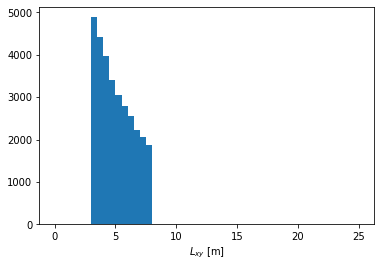

In [1237]:
#Inspect LLPs
lxy = (sig_file["llp_Lxy"].array())
#lz = (sig_file["llp_Lz"].array()) Use for Endcap only
llp_eta = (sig_file["llp_eta"].array())
llp_phi = sig_file['llp_phi'].array()

#Produce plot of fiducial region of MS
(ak.flatten(sig_file["llp_pdgId"].array()))
L=ak.flatten(sig_file["llp_Lxy"].array())

ms_sig_mask = (sig_file["llp_Lxy"].array()/1000 < 8) & (sig_file["llp_Lxy"].array()/1000 > 3)

plt.hist(ak.flatten(sig_file["llp_Lxy"].array()[ms_sig_mask])/1000.0, bins=50, range=(0, 25))
plt.xlabel('$L_{xy}$ [m]')

In [1238]:
#Perform eta cuts on barrel
#### WILL NEED A SECOND TRAINING SET FOR CUTS ON THE ENDCAP #####
llp_cut = ((lxy > 3000) & (lxy < 8000)) & (abs(llp_eta) < 0.7)

In [1266]:
#Split the two LLPs into two arrays and create series
llp_np = ak.to_numpy(llp_cut)
#llp1 = pd.Series(llp_np[:,0], name='LLP1')
#llp2 = pd.Series(llp_np[:,1], name='LLP2')
num_llp = (np.zeros((len(llp_np))))
for i in range(len(llp_np)):
    num_llp[i] = np.sum(llp_np[i])
num_llps = pd.Series(num_llp, name='# of LLPs')
num_llps = dup_row(num_llps, dup_index)

In [1267]:
#Calculate dR for LLPs
#Find delta llp - vtx and pick jet with smallest delta
etaPairs = ak.cartesian({"x":llp_eta, "y":vtx_eta}, axis=1) 
phiPairs = ak.cartesian({"x":llp_phi, "y":vtx_phi}, axis=1) 

delta_eta = abs(etaPairs["x"] - etaPairs["y"])
delta_phi = abs(phiPairs["x"] - phiPairs["y"])

delta_llp = (delta_eta * delta_eta) + (delta_phi * delta_phi)

In [1268]:
# Algorithm to pick minimum values based on vtx indices
results = []

for idx, val in enumerate(dummy_vtx):
    llp_vals = delta_llp[idx]
    result = []
    for j in range(len(val)):
        # Find the corresponding llp values (2 values for each vtx value)
        min_val = min(llp_vals[j*2], llp_vals[j*2+1])
        result.append(min_val)
    results.append(result)

# Convert results to an awkward array
result_array = ak.Array(results)



In [1269]:
#Concatenate onto existing df
delta_llp = ak.to_numpy(ak.flatten(result_array))
delta_llps = pd.Series(delta_llp, name='Delta_LLP')
df_llp = pd.concat([df_vtx_jet_track,num_llps,delta_llps], axis=1)

## Build Training Set

In [1270]:
#Create target
label_series=pd.Series(np.zeros(len(eventnps)),name='Label')

#Create df
df = pd.concat([df_llp, label_series], axis=1)

In [1271]:
#Now remove bad vertices
df_clean = df[df['MDT']!= -99999] 
df_clean
#Looks Good!

,Event #,Mult,MDT,RPC,TGC,ntrks,Vtx_eta,Vtx_phi,Vtx_Sum_pT,jet_pt_1,jet_eta_1,jet_phi_1,jet_logRatio_1,jet_jvt_1,delta_jet_1,jet_pt_2,jet_eta_2,jet_phi_2,jet_logRatio_2,jet_jvt_2,delta_jet_2,jet_pt_3,jet_eta_3,jet_phi_3,jet_logRatio_3,jet_jvt_3,delta_jet_3,track_pt_1,delta_track_1,track_pt_2,delta_track_2,track_pt_3,delta_track_3,# of LLPs,Delta_LLP,Label
4,4,1.0,1381,0,1127,4,-1.700868,-1.715319,0.000000,24.957029,-1.495608,-0.368880,-0.052691,0.048619,1.855028,226.896344,-0.770952,0.904551,0.045952,1.000000,7.728460,12.894346,-2.476266,2.784983,-999.000000,0.003402,20.853958,1.147775,0.040775,0.521837,0.079242,0.828553,0.302267,0.0,0.113792,0.0
6,6,2.0,2031,1975,1063,9,-1.037559,-0.770241,0.000000,35.684297,0.011543,-0.755410,-1.320905,0.993449,1.100835,10.515792,-0.439783,-2.031501,-999.000000,0.001267,4.644983,23.944773,1.865306,0.483324,-0.671974,0.101785,1.496697,0.613037,4.474674,3.212698,0.048480,0.971644,17.411636,0.0,11.699512,0.0
7,6,2.0,2069,1842,1126,3,-1.211802,-0.766565,658.664118,35.684297,0.011543,-0.755410,-1.320905,0.993449,1.100835,10.515792,-0.439783,-2.031501,-999.000000,0.001267,4.644983,23.944773,1.865306,0.483324,-0.671974,0.101785,1.496697,0.613037,4.474674,3.212698,0.048480,0.971644,17.411636,0.0,0.002311,0.0
13,12,1.0,685,0,752,13,-1.606205,-2.919309,544.256762,57.891586,-1.665196,-1.550996,-0.719179,0.997333,1.875761,8.525940,-0.787428,-1.071599,-0.277191,0.049303,4.084428,21.577754,-3.750784,-2.355356,-1.483802,-0.100000,4.917262,0.544257,0.037354,1.140319,0.140150,0.511258,0.271650,0.0,0.001829,0.0
14,13,1.0,905,443,10,7,0.903355,1.364382,0.000000,104.588023,1.024100,1.331153,0.999648,0.000000,0.015684,12.280291,2.078086,0.976894,-999.000000,0.005140,1.530140,17.066615,2.510036,1.054231,1.233338,0.987627,2.677616,0.735222,0.006991,0.925647,0.016870,0.613694,0.253873,0.0,0.000518,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51033,49970,1.0,1600,27,2103,14,-1.502829,0.858940,0.000000,13.368660,-2.323307,0.460888,-1.079282,0.969865,0.831629,20.585318,-2.619824,1.917696,0.649583,0.000000,2.368642,14.521675,0.203826,0.250056,-0.594458,0.003534,3.283413,0.522350,0.186059,0.826353,0.282846,0.819133,0.326950,0.0,0.006271,0.0
51036,49973,1.0,939,0,802,13,2.518463,-0.807060,0.000000,17.975713,2.453505,-1.562395,-0.027724,0.895586,0.574751,10.214925,0.936493,-2.070850,-1.335226,0.000000,4.099794,12.819567,0.446360,-0.519919,-0.578253,0.000000,4.376061,0.982866,0.105552,1.187846,0.147737,0.669099,0.150840,0.0,0.280546,0.0
51038,49975,1.0,3118,887,2151,9,1.342875,2.523968,0.000000,13.989411,0.445719,2.965230,-3.285725,0.000000,0.999600,15.313028,1.586658,1.298195,-2.104362,0.000000,1.561952,264.752594,0.155350,0.733408,-0.015225,0.000000,4.616323,0.749262,0.882799,0.661827,2.211788,0.715794,4.176990,0.0,0.012987,0.0
51042,49979,1.0,777,1488,0,8,-0.286740,-2.810499,0.000000,9.737639,0.493112,-3.118648,-1.722189,0.936098,0.703125,11.218172,-1.320836,-2.404762,-0.420577,0.320640,1.233977,21.999367,1.474297,-2.510150,-0.902392,0.905650,3.191462,1.039542,0.239182,0.500215,0.368266,2.298146,0.429527,1.0,0.000985,0.0


In [1272]:
#Create columns containing LLP data
df['# of LLPs'] = df['# of LLPs'].astype(int)
df['Event #'] = df['Event #'].astype(int)
df['Label'] = df['Label'].astype(int)

In [1273]:
#Assign Label =1 to appropriate vertices
# Ensure 'Delta_LLP' is float and handle NaNs
df['Delta_LLP'] = pd.to_numeric(df['Delta_LLP'], errors='coerce')

# Process each group to determine the labels
def process_group(group):
    # Calculate the number of LLPs that need to be assigned within this group
    number_llp = group['# of LLPs'].max()
    # Sort group by distance, but keep the original index to restore order later
    sorted_indices = group['Delta_LLP'].nsmallest(number_llp).index if number_llp > 0 else []
    # Set the 'Label' to 1 for the rows with the shortest distances
    group.loc[sorted_indices, 'Label'] = 1
    return group

# Group by 'Event' and apply the labeling logic
df = df.groupby('Event #').apply(process_group).reset_index(drop=True)


In [1274]:
df_train=df[df['MDT']!=-99999]

In [1275]:
df_train

,Event #,Mult,MDT,RPC,TGC,ntrks,Vtx_eta,Vtx_phi,Vtx_Sum_pT,jet_pt_1,jet_eta_1,jet_phi_1,jet_logRatio_1,jet_jvt_1,delta_jet_1,jet_pt_2,jet_eta_2,jet_phi_2,jet_logRatio_2,jet_jvt_2,delta_jet_2,jet_pt_3,jet_eta_3,jet_phi_3,jet_logRatio_3,jet_jvt_3,delta_jet_3,track_pt_1,delta_track_1,track_pt_2,delta_track_2,track_pt_3,delta_track_3,# of LLPs,Delta_LLP,Label
4,4,1.0,1381,0,1127,4,-1.700868,-1.715319,0.000000,24.957029,-1.495608,-0.368880,-0.052691,0.048619,1.855028,226.896344,-0.770952,0.904551,0.045952,1.000000,7.728460,12.894346,-2.476266,2.784983,-999.000000,0.003402,20.853958,1.147775,0.040775,0.521837,0.079242,0.828553,0.302267,0,0.113792,0
6,6,2.0,2031,1975,1063,9,-1.037559,-0.770241,0.000000,35.684297,0.011543,-0.755410,-1.320905,0.993449,1.100835,10.515792,-0.439783,-2.031501,-999.000000,0.001267,4.644983,23.944773,1.865306,0.483324,-0.671974,0.101785,1.496697,0.613037,4.474674,3.212698,0.048480,0.971644,17.411636,0,11.699512,0
7,6,2.0,2069,1842,1126,3,-1.211802,-0.766565,658.664118,35.684297,0.011543,-0.755410,-1.320905,0.993449,1.100835,10.515792,-0.439783,-2.031501,-999.000000,0.001267,4.644983,23.944773,1.865306,0.483324,-0.671974,0.101785,1.496697,0.613037,4.474674,3.212698,0.048480,0.971644,17.411636,0,0.002311,0
13,12,1.0,685,0,752,13,-1.606205,-2.919309,544.256762,57.891586,-1.665196,-1.550996,-0.719179,0.997333,1.875761,8.525940,-0.787428,-1.071599,-0.277191,0.049303,4.084428,21.577754,-3.750784,-2.355356,-1.483802,-0.100000,4.917262,0.544257,0.037354,1.140319,0.140150,0.511258,0.271650,0,0.001829,0
14,13,1.0,905,443,10,7,0.903355,1.364382,0.000000,104.588023,1.024100,1.331153,0.999648,0.000000,0.015684,12.280291,2.078086,0.976894,-999.000000,0.005140,1.530140,17.066615,2.510036,1.054231,1.233338,0.987627,2.677616,0.735222,0.006991,0.925647,0.016870,0.613694,0.253873,0,0.000518,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51033,49970,1.0,1600,27,2103,14,-1.502829,0.858940,0.000000,13.368660,-2.323307,0.460888,-1.079282,0.969865,0.831629,20.585318,-2.619824,1.917696,0.649583,0.000000,2.368642,14.521675,0.203826,0.250056,-0.594458,0.003534,3.283413,0.522350,0.186059,0.826353,0.282846,0.819133,0.326950,0,0.006271,0
51036,49973,1.0,939,0,802,13,2.518463,-0.807060,0.000000,17.975713,2.453505,-1.562395,-0.027724,0.895586,0.574751,10.214925,0.936493,-2.070850,-1.335226,0.000000,4.099794,12.819567,0.446360,-0.519919,-0.578253,0.000000,4.376061,0.982866,0.105552,1.187846,0.147737,0.669099,0.150840,0,0.280546,0
51038,49975,1.0,3118,887,2151,9,1.342875,2.523968,0.000000,13.989411,0.445719,2.965230,-3.285725,0.000000,0.999600,15.313028,1.586658,1.298195,-2.104362,0.000000,1.561952,264.752594,0.155350,0.733408,-0.015225,0.000000,4.616323,0.749262,0.882799,0.661827,2.211788,0.715794,4.176990,0,0.012987,0
51042,49979,1.0,777,1488,0,8,-0.286740,-2.810499,0.000000,9.737639,0.493112,-3.118648,-1.722189,0.936098,0.703125,11.218172,-1.320836,-2.404762,-0.420577,0.320640,1.233977,21.999367,1.474297,-2.510150,-0.902392,0.905650,3.191462,1.039542,0.239182,0.500215,0.368266,2.298146,0.429527,1,0.000985,1


In [1276]:
#Check dataframe for NaN values
nan_counts = df_train.isna().sum()
print(nan_counts)

Event #           0
Mult              0
MDT               0
RPC               0
TGC               0
ntrks             0
Vtx_eta           0
Vtx_phi           0
Vtx_Sum_pT        0
jet_pt_1          4
jet_eta_1         4
jet_phi_1         4
jet_logRatio_1    4
jet_jvt_1         4
delta_jet_1       4
jet_pt_2          4
jet_eta_2         4
jet_phi_2         4
jet_logRatio_2    4
jet_jvt_2         4
delta_jet_2       4
jet_pt_3          4
jet_eta_3         4
jet_phi_3         4
jet_logRatio_3    4
jet_jvt_3         4
delta_jet_3       4
track_pt_1        0
delta_track_1     0
track_pt_2        0
delta_track_2     0
track_pt_3        0
delta_track_3     0
# of LLPs         0
Delta_LLP         0
Label             0
dtype: int64


In [1277]:
#Check nan's and make sure they correspond to entries where there are no jets
nan_mask = df_train['jet_pt_1'].isna()
nan_indices = df_train['jet_pt_1'][nan_mask].index
nan_indices_array = nan_indices.to_numpy()
nan_indices_array

#Verify that these are indeed due to divide by zero operations and change to -99999 if so. 
#Compare with zero_length_indices_jet
set(nan_indices_array).issubset(set(jet_length_indices))

False

In [1278]:
#Let's inspect these four entries and make sure there isn't contamination of data
# Define a boolean mask
mask = df_train.index.isin(nan_indices_array)

# Apply the mask
selected_rows = df_train[mask]
selected_rows

,Event #,Mult,MDT,RPC,TGC,ntrks,Vtx_eta,Vtx_phi,Vtx_Sum_pT,jet_pt_1,jet_eta_1,jet_phi_1,jet_logRatio_1,jet_jvt_1,delta_jet_1,jet_pt_2,jet_eta_2,jet_phi_2,jet_logRatio_2,jet_jvt_2,delta_jet_2,jet_pt_3,jet_eta_3,jet_phi_3,jet_logRatio_3,jet_jvt_3,delta_jet_3,track_pt_1,delta_track_1,track_pt_2,delta_track_2,track_pt_3,delta_track_3,# of LLPs,Delta_LLP,Label
9195,9005,1.0,1837,0,1377,13,-2.048273,-0.261915,542.913105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.542913,0.027086,1.279832,0.594491,0.698373,1.620307,1,0.014546,1
28795,28202,2.0,1359,1801,53,5,0.698519,-2.406394,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.711438,13.201002,0.922605,12.472059,0.674879,0.420296,1,0.086271,0
28796,28202,2.0,587,6,799,6,1.335054,0.566670,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.711438,13.201002,0.922605,12.472059,0.674879,0.420296,1,0.004381,1
33431,32728,1.0,1046,364,961,4,1.159140,-0.290413,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.161956,0.118528,0.530513,0.616349,0.714670,0.715453,1,0.013967,1


In [1279]:
#There are 4 vertices, 3 of which have an LLP associated with it. Let's confrim that there is indeed no jet
    #and not jus a contamination of data

event_array=selected_rows['Event #'].to_numpy()
for i,j in enumerate(event_array):
    if len(jet_pt[j]) > 0:
        print("jet has data")
    else: print("Jet has no data")

Jet has no data
Jet has no data
Jet has no data
Jet has no data


In [1280]:
#The jets do indeed have no data, these are excellent candidates for LLPs

#Replace these values with -99999
df_train.fillna(-99999, inplace=True)
#Verify
nan_counts = df_train.isna().sum()
print(nan_counts)

Event #           0
Mult              0
MDT               0
RPC               0
TGC               0
ntrks             0
Vtx_eta           0
Vtx_phi           0
Vtx_Sum_pT        0
jet_pt_1          0
jet_eta_1         0
jet_phi_1         0
jet_logRatio_1    0
jet_jvt_1         0
delta_jet_1       0
jet_pt_2          0
jet_eta_2         0
jet_phi_2         0
jet_logRatio_2    0
jet_jvt_2         0
delta_jet_2       0
jet_pt_3          0
jet_eta_3         0
jet_phi_3         0
jet_logRatio_3    0
jet_jvt_3         0
delta_jet_3       0
track_pt_1        0
delta_track_1     0
track_pt_2        0
delta_track_2     0
track_pt_3        0
delta_track_3     0
# of LLPs         0
Delta_LLP         0
Label             0
dtype: int64


/Users/christopheralpert/miniconda3/lib/python3.8/site-packages/pandas/core/frame.py:4459: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [1281]:
#Check any other erroneous values that may be messing with the data
# Dictionary to store the counts
neg_999_counts = {}

# Iterate over each column and count the occurrences of -999
for column in df_train.columns:
    count = (df_train[column] == -999).sum()  # Counting how many times -999 appears in the column
    neg_999_counts[column] = count

# Print the result
for feature, count in neg_999_counts.items():
    if count >0:
        print(f"{feature}: {count} occurrences of -999")

jet_logRatio_1: 1185 occurrences of -999
jet_logRatio_2: 1263 occurrences of -999
jet_logRatio_3: 1251 occurrences of -999


In [1282]:
#Inspect these events
mask = df_train['jet_logRatio_1']== -999
indices = df_train['jet_logRatio_1'][mask].index
indices_array = indices.to_numpy()

#Let's inspect these four entries and make sure there isn't contamination of data
# Define a boolean mask
mask = df_train.index.isin(indices_array)

# Apply the mask
selected_rows = df_train[mask]
selected_rows

,Event #,Mult,MDT,RPC,TGC,ntrks,Vtx_eta,Vtx_phi,Vtx_Sum_pT,jet_pt_1,jet_eta_1,jet_phi_1,jet_logRatio_1,jet_jvt_1,delta_jet_1,jet_pt_2,jet_eta_2,jet_phi_2,jet_logRatio_2,jet_jvt_2,delta_jet_2,jet_pt_3,jet_eta_3,jet_phi_3,jet_logRatio_3,jet_jvt_3,delta_jet_3,track_pt_1,delta_track_1,track_pt_2,delta_track_2,track_pt_3,delta_track_3,# of LLPs,Delta_LLP,Label
101,99,1.0,1113,0,954,4,1.845415,1.662423,2965.652943,28.440072,0.733473,1.923383,-999.0,0.000000,1.304516,14.942190,0.330911,1.572860,-0.551302,0.055751,2.301745,6.011940,0.256580,2.303532,-999.000000,0.005073,2.935420,1.039012,0.009298,1.950620,0.029650,0.527035,0.072332,0,0.024823,0
108,106,1.0,544,120,503,3,1.148304,-0.792710,1060.750993,5.614411,1.142591,-1.247874,-999.0,0.282926,0.207206,19.111750,0.537860,-0.131566,-0.862704,0.412514,0.809753,10.398036,-0.581893,-0.760877,-0.675706,0.396860,2.994595,1.060751,0.033762,0.624525,0.105438,0.724121,0.119928,0,0.013213,0
109,107,1.0,2008,3267,103,3,0.702595,-0.589454,0.000000,10.208044,0.711840,-1.131409,-999.0,0.977233,0.293801,40.947898,0.814685,0.392268,-0.378140,0.990000,0.976343,7.729772,0.289114,0.793435,-1.114677,0.039622,2.083348,3.646667,0.197243,0.788615,0.204940,3.754567,0.218574,0,0.000110,0
130,128,1.0,1880,1781,810,3,1.051309,-0.162973,0.000000,9.762127,0.300032,0.038379,-999.0,0.000000,0.604960,12.589293,-0.031929,-0.525535,-0.993576,0.225020,1.304856,43.960496,0.678823,-1.440429,-0.749291,0.041349,1.770640,0.593041,0.363400,1.912266,0.822118,0.825461,0.979746,0,0.036611,0
160,156,1.0,780,0,508,3,-1.644941,-0.201130,0.000000,15.852327,0.725592,1.042728,-999.0,0.000000,7.166610,11.741105,0.971201,-1.745125,-0.153039,0.000000,9.228113,32.292393,0.653488,2.336084,-0.128999,0.996249,11.720231,0.964588,0.255220,0.886238,0.399419,0.674855,0.899729,0,0.000225,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50671,49615,1.0,1064,2027,5,6,0.487493,-2.323810,0.000000,9.441012,-1.168621,-2.081327,-999.0,0.011785,2.801512,12.235272,1.845795,-0.938080,-1.155972,0.000000,3.765233,17.857369,-1.823219,-1.431495,-999.000000,0.002014,6.135619,1.245558,0.265766,1.452234,0.316867,0.983993,0.510253,1,0.001267,1
50678,49622,1.0,1501,172,1183,3,1.247343,0.754038,0.000000,10.678102,0.533540,-0.381238,-999.0,0.967926,1.798367,13.909571,2.304608,-0.635074,-0.751654,0.476909,3.047441,26.062596,0.027527,2.051727,-1.081294,0.355720,3.171947,0.545242,0.181958,0.589590,0.226898,0.707751,0.587288,0,0.002116,0
50687,49631,1.0,1703,1207,938,4,-1.109229,-1.740831,0.000000,9.514850,-0.675339,-1.597702,-999.0,0.000000,0.208747,10.993283,-0.772711,-2.801846,-1.090343,-0.100000,1.238998,8.779849,0.241258,-2.333187,-2.422909,-0.100000,2.174703,0.586312,0.083348,0.515970,0.142717,0.542552,0.244337,0,0.016986,0
50953,49892,1.0,2454,2260,511,4,-1.080766,2.450810,0.000000,8.607695,-0.288261,2.156040,-999.0,0.239203,0.714954,36.427363,-0.433604,1.299257,-0.606232,0.990448,1.744895,21.782021,0.190751,1.675763,-1.184896,0.336665,2.217454,0.577316,0.148910,0.511829,0.184690,0.908503,0.429678,1,0.180714,1


In [1283]:
#Check to see if these rows have any LLPs
selected_rows[selected_rows['Label']==1]

,Event #,Mult,MDT,RPC,TGC,ntrks,Vtx_eta,Vtx_phi,Vtx_Sum_pT,jet_pt_1,jet_eta_1,jet_phi_1,jet_logRatio_1,jet_jvt_1,delta_jet_1,jet_pt_2,jet_eta_2,jet_phi_2,jet_logRatio_2,jet_jvt_2,delta_jet_2,jet_pt_3,jet_eta_3,jet_phi_3,jet_logRatio_3,jet_jvt_3,delta_jet_3,track_pt_1,delta_track_1,track_pt_2,delta_track_2,track_pt_3,delta_track_3,# of LLPs,Delta_LLP,Label
215,210,1.0,1774,3285,0,9,0.162754,-0.479227,712.977173,17.412109,0.386726,-0.335456,-999.0,0.963571,0.070834,24.245299,0.235449,-1.360385,-0.367611,0.005297,0.781724,11.073011,1.054017,-1.225398,-1.698441,0.295474,1.351120,0.712977,0.023132,0.825190,0.094181,2.329801,0.148528,1,0.006851,1
860,843,1.0,2973,4211,9,4,-0.640134,-2.340177,557.257413,12.297249,0.522225,-0.367848,-999.0,0.000000,5.241160,9.375689,1.352832,0.066392,-0.084358,0.313324,9.763487,9.759964,0.551790,1.316183,-3.050594,0.034036,14.789649,0.557257,0.034871,0.837787,0.082499,1.704970,0.245759,1,0.015471,1
977,959,1.0,508,547,0,7,0.086887,-2.892612,0.000000,8.234401,0.851481,-2.688893,-999.0,0.000000,0.626105,23.386711,0.202772,-1.854682,-0.220696,0.000000,1.090729,11.732788,-0.559250,-1.867633,-0.577672,0.000000,1.468075,0.517803,0.577955,1.013607,0.698404,0.793708,0.762494,1,0.000436,1
1098,1077,1.0,2330,4312,0,3,0.337409,0.442613,0.000000,26.580488,0.733442,1.010600,-999.0,0.010886,0.479452,11.351190,1.184162,0.642001,-1.687928,0.948237,0.756747,6.104332,1.507378,-0.037972,-0.500326,0.027016,1.599791,3.109103,0.421519,1.652724,0.460616,1.681031,0.519675,1,0.002921,1
1112,1091,1.0,1662,2683,0,6,0.510052,-2.475035,0.000000,13.311844,-0.668023,-2.086632,-999.0,0.118313,1.538718,8.755387,1.732081,-2.694612,-999.000000,0.000000,1.541569,15.259387,1.556586,-0.054446,-0.739717,0.000000,6.954487,0.700349,1.189958,1.230657,1.439886,0.591982,1.471650,1,0.007131,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50349,49293,1.0,2409,3910,15,5,-0.590891,1.442167,0.000000,7.670215,-0.763873,2.433127,-999.0,0.000781,1.011926,18.360584,0.478703,1.538006,-1.639894,0.000000,1.153217,29.768385,-1.570134,0.937287,-0.415701,0.003288,1.213821,0.512615,0.083798,2.260467,0.828359,3.882656,0.851472,1,0.000483,1
50424,49368,1.0,1872,2601,427,3,-1.032825,1.102502,0.000000,14.375157,-0.724992,1.296478,-999.0,0.999503,0.132388,28.283557,-1.089764,1.688124,-0.167772,0.000000,0.346195,17.912393,-0.008974,0.667990,-1.321988,0.018600,1.237073,3.585536,0.160364,5.819139,0.191392,0.523446,0.211362,1,0.058429,1
50671,49615,1.0,1064,2027,5,6,0.487493,-2.323810,0.000000,9.441012,-1.168621,-2.081327,-999.0,0.011785,2.801512,12.235272,1.845795,-0.938080,-1.155972,0.000000,3.765233,17.857369,-1.823219,-1.431495,-999.000000,0.002014,6.135619,1.245558,0.265766,1.452234,0.316867,0.983993,0.510253,1,0.001267,1
50953,49892,1.0,2454,2260,511,4,-1.080766,2.450810,0.000000,8.607695,-0.288261,2.156040,-999.0,0.239203,0.714954,36.427363,-0.433604,1.299257,-0.606232,0.990448,1.744895,21.782021,0.190751,1.675763,-1.184896,0.336665,2.217454,0.577316,0.148910,0.511829,0.184690,0.908503,0.429678,1,0.180714,1


In [1284]:
#Drop the rows
df = df_train.drop(indices_array)

In [1285]:
#Drop LLP columns from training set
df.drop(['# of LLPs', 'Delta_LLP'], axis=1, inplace=True)

In [1286]:
df

,Event #,Mult,MDT,RPC,TGC,ntrks,Vtx_eta,Vtx_phi,Vtx_Sum_pT,jet_pt_1,jet_eta_1,jet_phi_1,jet_logRatio_1,jet_jvt_1,delta_jet_1,jet_pt_2,jet_eta_2,jet_phi_2,jet_logRatio_2,jet_jvt_2,delta_jet_2,jet_pt_3,jet_eta_3,jet_phi_3,jet_logRatio_3,jet_jvt_3,delta_jet_3,track_pt_1,delta_track_1,track_pt_2,delta_track_2,track_pt_3,delta_track_3,Label
4,4,1.0,1381,0,1127,4,-1.700868,-1.715319,0.000000,24.957029,-1.495608,-0.368880,-0.052691,0.048619,1.855028,226.896344,-0.770952,0.904551,0.045952,1.000000,7.728460,12.894346,-2.476266,2.784983,-999.000000,0.003402,20.853958,1.147775,0.040775,0.521837,0.079242,0.828553,0.302267,0
6,6,2.0,2031,1975,1063,9,-1.037559,-0.770241,0.000000,35.684297,0.011543,-0.755410,-1.320905,0.993449,1.100835,10.515792,-0.439783,-2.031501,-999.000000,0.001267,4.644983,23.944773,1.865306,0.483324,-0.671974,0.101785,1.496697,0.613037,4.474674,3.212698,0.048480,0.971644,17.411636,0
7,6,2.0,2069,1842,1126,3,-1.211802,-0.766565,658.664118,35.684297,0.011543,-0.755410,-1.320905,0.993449,1.100835,10.515792,-0.439783,-2.031501,-999.000000,0.001267,4.644983,23.944773,1.865306,0.483324,-0.671974,0.101785,1.496697,0.613037,4.474674,3.212698,0.048480,0.971644,17.411636,0
13,12,1.0,685,0,752,13,-1.606205,-2.919309,544.256762,57.891586,-1.665196,-1.550996,-0.719179,0.997333,1.875761,8.525940,-0.787428,-1.071599,-0.277191,0.049303,4.084428,21.577754,-3.750784,-2.355356,-1.483802,-0.100000,4.917262,0.544257,0.037354,1.140319,0.140150,0.511258,0.271650,0
14,13,1.0,905,443,10,7,0.903355,1.364382,0.000000,104.588023,1.024100,1.331153,0.999648,0.000000,0.015684,12.280291,2.078086,0.976894,-999.000000,0.005140,1.530140,17.066615,2.510036,1.054231,1.233338,0.987627,2.677616,0.735222,0.006991,0.925647,0.016870,0.613694,0.253873,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51033,49970,1.0,1600,27,2103,14,-1.502829,0.858940,0.000000,13.368660,-2.323307,0.460888,-1.079282,0.969865,0.831629,20.585318,-2.619824,1.917696,0.649583,0.000000,2.368642,14.521675,0.203826,0.250056,-0.594458,0.003534,3.283413,0.522350,0.186059,0.826353,0.282846,0.819133,0.326950,0
51036,49973,1.0,939,0,802,13,2.518463,-0.807060,0.000000,17.975713,2.453505,-1.562395,-0.027724,0.895586,0.574751,10.214925,0.936493,-2.070850,-1.335226,0.000000,4.099794,12.819567,0.446360,-0.519919,-0.578253,0.000000,4.376061,0.982866,0.105552,1.187846,0.147737,0.669099,0.150840,0
51038,49975,1.0,3118,887,2151,9,1.342875,2.523968,0.000000,13.989411,0.445719,2.965230,-3.285725,0.000000,0.999600,15.313028,1.586658,1.298195,-2.104362,0.000000,1.561952,264.752594,0.155350,0.733408,-0.015225,0.000000,4.616323,0.749262,0.882799,0.661827,2.211788,0.715794,4.176990,0
51042,49979,1.0,777,1488,0,8,-0.286740,-2.810499,0.000000,9.737639,0.493112,-3.118648,-1.722189,0.936098,0.703125,11.218172,-1.320836,-2.404762,-0.420577,0.320640,1.233977,21.999367,1.474297,-2.510150,-0.902392,0.905650,3.191462,1.039542,0.239182,0.500215,0.368266,2.298146,0.429527,1


In [1287]:
#export df
df.to_csv('sig_train_barrel',index=False)

In [1264]:
#Inspect # of LLPs
LLPs=len(df[df['Label']==1])
LLPs

3048